In [11]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
from sklearn import datasets

In [6]:
bcancer = datasets.load_breast_cancer()
X = bcancer.data  
y = bcancer.target
X = StandardScaler().fit_transform(X)

In [7]:
x_neg=X[y==0]
x_pos=X[y==1]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(212, 30)
(357, 30)


In [8]:
indices=np.arange(106)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:106]
x_train=np.concatenate((np.array(x_neg[0:106])[indices],x_pos)).reshape(-1,30)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [9]:
x_test = x_neg[106:212].reshape(-1,30)
y_test = y_neg[106:212].reshape(-1,1)

# Projection model

In [12]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [13]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create filter(sec): %f \n\n\n" % (m,fpr_test,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]

In [14]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []
times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10,10,300,100,fpr_values,size_values,times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(357, 30)
Size: 10 Bits - FPR: 0.462264 - Time Taken to create filter(sec): 0.377990 



Size: 20 Bits - FPR: 0.358491 - Time Taken to create filter(sec): 0.485900 



Size: 30 Bits - FPR: 0.283019 - Time Taken to create filter(sec): 0.329923 



Size: 40 Bits - FPR: 0.320755 - Time Taken to create filter(sec): 0.305634 



Size: 50 Bits - FPR: 0.311321 - Time Taken to create filter(sec): 0.331826 



Size: 60 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.301353 



Size: 70 Bits - FPR: 0.216981 - Time Taken to create filter(sec): 0.308213 



Size: 80 Bits - FPR: 0.396226 - Time Taken to create filter(sec): 0.279732 



Size: 90 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.298808 



Size: 100 Bits - FPR: 0.254717 - Time Taken to create filter(sec): 0.266894 



Size: 110 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.312742 



Size: 120 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.274898 



Size: 1

Size: 1030 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.288622 



Size: 1040 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.250068 



Size: 1050 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.313155 



Size: 1060 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.348890 



Size: 1070 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.463663 



Size: 1080 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.249002 



Size: 1090 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.259396 



Size: 1100 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.256570 



Size: 1110 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.264527 



Size: 1120 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.252623 



Size: 1130 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.313536 



Size: 1140 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.352236 



Size: 1150 Bits - FPR: 0.047

Size: 2050 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.398727 



Size: 2060 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.381628 



Size: 2070 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.427685 



Size: 2080 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.348564 



Size: 2090 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.355226 



Size: 2100 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.366395 



Size: 2110 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.407788 



Size: 2120 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.362629 



Size: 2130 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.353690 



Size: 2140 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.353963 



Size: 2150 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.484035 



Size: 2160 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.430571 



Size: 2170 Bits - FPR: 0.028

Size: 60 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.294848 



Size: 70 Bits - FPR: 0.311321 - Time Taken to create filter(sec): 0.300046 



Size: 80 Bits - FPR: 0.386792 - Time Taken to create filter(sec): 0.291386 



Size: 90 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.296857 



Size: 100 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.299241 



Size: 110 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.294384 



Size: 120 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.337061 



Size: 130 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.285838 



Size: 140 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.277674 



Size: 150 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.276563 



Size: 160 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.284923 



Size: 170 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.283143 



Size: 180 Bits - FPR: 0.235849 - Time Taken 

Size: 1090 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.424348 



Size: 1100 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.299880 



Size: 1110 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.243846 



Size: 1120 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.223603 



Size: 1130 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.282444 



Size: 1140 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.285672 



Size: 1150 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.256476 



Size: 1160 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.290090 



Size: 1170 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.438799 



Size: 1180 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.256553 



Size: 1190 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.245024 



Size: 1200 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.333696 



Size: 1210 Bits - FPR: 0.037

Size: 2110 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.364124 



Size: 2120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.307807 



Size: 2130 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.357016 



Size: 2140 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.356324 



Size: 2150 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.340241 



Size: 2160 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.328116 



Size: 2170 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.324652 



Size: 2180 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.313860 



Size: 2190 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.378476 



Size: 2200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.398837 



Size: 2210 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.335255 



Size: 2220 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.452766 



Size: 2230 Bits - FPR: 0.028

Size: 120 Bits - FPR: 0.245283 - Time Taken to create filter(sec): 0.274679 



Size: 130 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.279057 



Size: 140 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.277098 



Size: 150 Bits - FPR: 0.273585 - Time Taken to create filter(sec): 0.266176 



Size: 160 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.277382 



Size: 170 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.276073 



Size: 180 Bits - FPR: 0.283019 - Time Taken to create filter(sec): 0.444581 



Size: 190 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.480692 



Size: 200 Bits - FPR: 0.254717 - Time Taken to create filter(sec): 0.500893 



Size: 210 Bits - FPR: 0.292453 - Time Taken to create filter(sec): 0.485352 



Size: 220 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.290078 



Size: 230 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.280345 



Size: 240 Bits - FPR: 0.207547 - Time Ta

Size: 1150 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.402253 



Size: 1160 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.362472 



Size: 1170 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.350091 



Size: 1180 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.288080 



Size: 1190 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.332508 



Size: 1200 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.379607 



Size: 1210 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.446770 



Size: 1220 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.430443 



Size: 1230 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.413807 



Size: 1240 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.273684 



Size: 1250 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.294697 



Size: 1260 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.381763 



Size: 1270 Bits - FPR: 0.028

Size: 2170 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.329533 



Size: 2180 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.366111 



Size: 2190 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.337759 



Size: 2200 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.359030 



Size: 2210 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.368779 



Size: 2220 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.331029 



Size: 2230 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.300458 



Size: 2240 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.303717 



Size: 2250 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.341369 



Size: 2260 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.377414 



Size: 2270 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.370694 



Size: 2280 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.323930 



Size: 2290 Bits - FPR: 0.028

In [42]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//3):
    average_fprs += [((fpr_values[i] + fpr_values[(total_fprs//3)+i] + fpr_values[((2*total_fprs)//3)+i]))/3]
print(len(average_fprs))

300


# Normal Bloom Filter Values

In [19]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [20]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

900
[357]


# FPR Comparison between Projection Model and Normal Bloom Filter

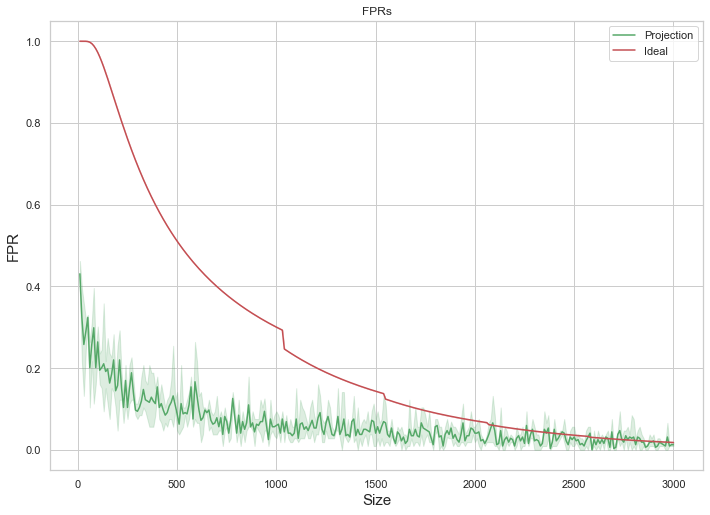

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [43]:
average_fprs = 3*average_fprs
print(len(average_fprs))

900


In [44]:
print(average_fprs)

[0.4308176100628931, 0.3238993710691824, 0.2578616352201258, 0.2893081761006289, 0.3238993710691824, 0.20125786163522016, 0.2578616352201258, 0.29874213836477986, 0.20125786163522016, 0.2641509433962264, 0.19496855345911954, 0.20125786163522016, 0.21069182389937105, 0.19182389937106917, 0.1981132075471698, 0.16352201257861634, 0.18553459119496854, 0.22012578616352205, 0.14465408805031446, 0.15723270440251572, 0.22012578616352205, 0.1509433962264151, 0.10377358490566037, 0.16981132075471703, 0.1037735849056604, 0.1509433962264151, 0.18867924528301885, 0.13836477987421383, 0.09748427672955977, 0.09433962264150945, 0.1037735849056604, 0.11949685534591196, 0.14779874213836477, 0.12264150943396228, 0.11949685534591196, 0.11635220125786162, 0.1289308176100629, 0.11949685534591196, 0.11320754716981134, 0.1540880503144654, 0.1037735849056604, 0.11320754716981134, 0.09748427672955974, 0.08490566037735849, 0.09119496855345914, 0.10691823899371071, 0.11635220125786165, 0.1320754716981132, 0.11006

In [45]:
saved_data = list(zip(size_values, y_ideal, fpr_values, average_fprs, times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time'])
df.head()

,Size of filter(bits),Ideal FPR,Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time
0,10,1.000000,0.462264,0.430818,0.377990
1,20,1.000000,0.358491,0.323899,0.485900
2,30,0.999994,0.283019,0.257862,0.329923
3,40,0.999881,0.320755,0.289308,0.305634
4,50,0.999263,0.311321,0.323899,0.331826


In [46]:
df.to_csv('E:\SURA Data\BreastCancer_rerun_epochs_100.csv')